# Analysis particles in NWES as function of Rep
In this notebook we trajectories of particles in the NWES as function of the particle Reynods number $Re_p$.  
This Reynolds number is preset and constant in the simulations. The particle's reynolds number affects the  
relative importance of the drag force in the simulations and thus we expect particles with higher $Re_p$ to  
be more flow following (and thus behave more like tracer particles).  
For particles with low $Re_p$ we observe that the coriolis force makes them cluster in specific places. We  
need to find a measure to quantify this behavoir. At the moment I am considering:    
- quantifiying density distribution (using vonoroi analysis?) 
- quantifying voids?


In [8]:
# import needed packages

#update reading in packages when rerunning this cell
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/src")
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from datetime import datetime, timedelta
from importlib import reload
import hexbin_functions as hexfunc
import h3
from shapely.geometry import shape, Point

hexfunc = reload(hexfunc)
# test version, it should be version 4
print(h3.__version__)

from analysis_functions_xr import trajectory_length, Haversine_list, calc_tidal_av
from analysis_functions import make_PDF, Haversine
from particle_characteristics_functions import factor_drag_white1991, factor_drag_Schiller1933, factor_drag_morrison2013, Re_particle

# plotstyle: 
plt.style.use('../python_style_Meike.mplstyle')
# markers
color_array = np.array(['c','orange','purple','green','navy'])
marker_array = np.array(['s','o','>','p'])
line_array = np.array(['-','--','-.',':'])
markerline_array = np.array(['-s','--o','-.>',':p'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4.2.1


In [9]:
# set needed constants
# set needed constants
Rearth = 6371 * 10**3 # in m,
deg2rad = np.pi / 180.
sec_in_hours= 3600
diameter = 0.2 #m
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water

In [10]:
# filenames
# import simulation data
Replist = np.array([1,10,100,1000])
coriolis = True
B = 0.68
tau = 2759.97
runtime =  timedelta(days=30)# timedelta(days=10)
land_handling = 'anti_beaching'
nparticles = 88347 # 52511
chunck_time = 100
loc = 'NWES'

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0), #]) #,
                        datetime(2023, 10, 1, 0, 0, 0, 0)])
                    #    datetime(2023, 11, 1, 0, 0, 0, 0) ,
                    #    datetime(2023, 12, 1, 0, 0, 0, 0) ])
                       #datetime(2024, 1, 1, 0, 0, 0, 0),
                       #datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)

base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'

basefile_Rep_constant = (base_directory + '{particle_type}/{loc}_'
                 'start{y_s:04d}_{m_s:02d}_{d_s:02d}_'
                 'end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_'
                 '_Rep_{Rep:04d}_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{coriolis}.zarr')

basefile_tracer  = (base_directory + '{particle_type}/{loc}_'
                        'start{y_s:04d}_{m_s:02d}_{d_s:02d}_'
                        'end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_{land_handling}.zarr')

particle_types = ['tracer','inertial_SM_Rep_constant','inertial_Rep_constant'] # 
simtype = {'tracer':'tracer','inertial_SM_Rep_constant':'SM MR','inertial_Rep_constant':'full MR'}

basefiles = {'tracer':basefile_tracer,
             'inertial_Rep_constant':basefile_Rep_constant,
             'inertial_SM_Rep_constant':basefile_Rep_constant
             }

for Rep in Replist:
    print(f'c({Rep}) = {factor_drag_white1991(Rep):.02f}')


c(1) = 1.14
c(10) = 1.77
c(100) = 4.94
c(1000) = 25.33


In [11]:
# read in data
data ={}
for pt in particle_types:
    data[pt]={}
    for coriolis in [True]:
        data[pt][coriolis]={}
        if(pt == 'tracer'):
            data[pt][coriolis][None]={}
        else:
            for Rep in Replist:
                data[pt][coriolis][Rep]={}


for pt in particle_types:
    for coriolis in [True]:
        for starttime in starttimes:
            print(starttime)
            endtime = starttime + runtime 
            date = f'{starttime.year:04d}/{starttime.month:02d}'
            if(pt == 'tracer'):
                print (pt)
                file = basefile_tracer.format(loc=loc,
                                            y_s=starttime.year,
                                            m_s=starttime.month,
                                            d_s=starttime.day,
                                            y_e=endtime.year,
                                            m_e=endtime.month,
                                            d_e=endtime.day,
                                            land_handling = land_handling, 
                                            coriolis = coriolis,
                                            particle_type = pt)
                
                ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['z'],
                                    decode_times=False) #,decode_cf=False)

                data[pt][coriolis][None][date]= ds 
            else:
                for Rep in Replist:
                    file = basefiles[pt].format(loc=loc,
                                                y_s=starttime.year,
                                                m_s=starttime.month,
                                                d_s=starttime.day,
                                                y_e=endtime.year,
                                                m_e=endtime.month,
                                                d_e=endtime.day,
                                                B = int(B * 1000), 
                                                tau = int(tau ),
                                                land_handling = land_handling, 
                                                coriolis = coriolis,
                                                particle_type = pt,
                                                Rep = Rep)
                    ds = xr.open_dataset(file,
                                        engine='zarr',
                                        chunks={'trajectory':nparticles, 'obs':chunck_time},
                                        drop_variables=['B','tau','z'],
                                        decode_times=False) #,decode_cf=False)

                    data[pt][coriolis][Rep][date]= ds 



2023-09-01 00:00:00
tracer
2023-10-01 00:00:00
tracer
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


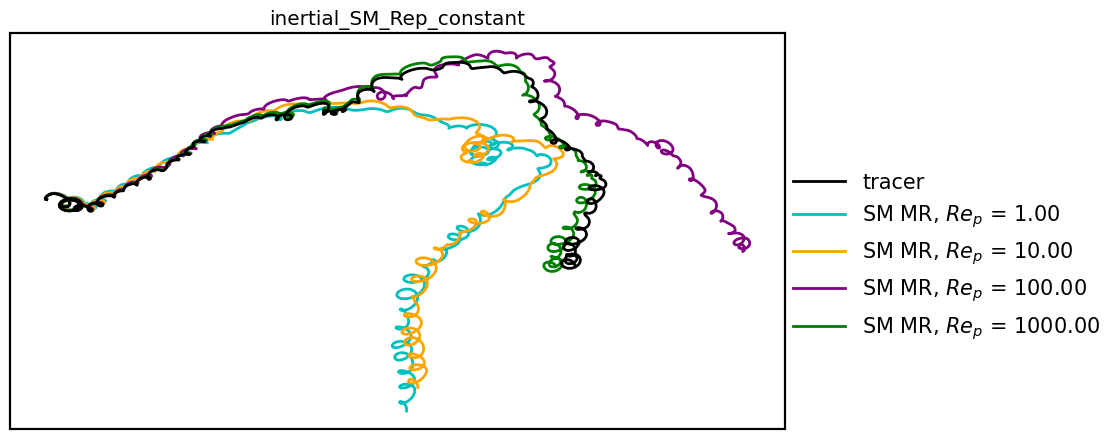

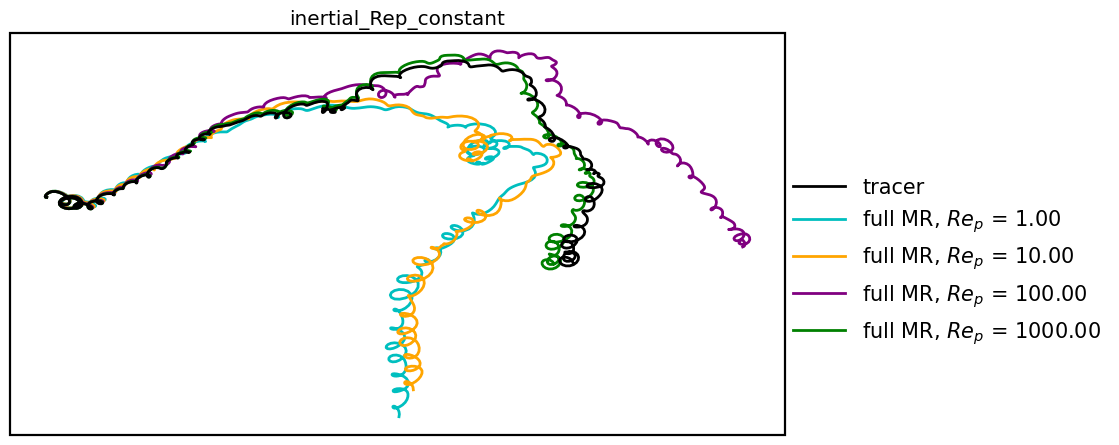

In [12]:
# plot selection of trajectories
for pt in particle_types[1:]:
        year=2023
        month=10
        date = f'{year:04d}/{month:02d}'
        legend= []
        coriolis = True
        fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
        ax.coastlines()
        idstart = 100#25680#47584#98
        idstep = 1
        idend = idstart+1 * idstep

        ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

        # plot tracer particle
        ax.plot(data['tracer'][coriolis][None][date].lon[idstart,0::1].T,
                data['tracer'][coriolis][None][date].lat[idstart,0::1].T,
                '-',
                color='k',zorder=20);
        legend.append('tracer')

        # ax.legend(particle_types,loc=(1,0.2))
        # pt = 'inertial_SM_Rep_constant'
        for Rep, color in zip(Replist,color_array):
                ax.plot(data[pt][coriolis][Rep][date].lon[idstart:idend:idstep,0::1].T,
                        data[pt][coriolis][Rep][date].lat[idstart:idend:idstep,0::1].T,
                        '-',
                        color=color);

                legend.append(simtype[pt]+', $Re_p$ = {:.02f}'.format(Rep))
        ax.legend(legend, loc=(1,0.2),fontsize=15) 
        ax.set_title(pt)


# conclusion Rep = 0, 1, 10 clearly different (but themselves very similar), 100 di

In [13]:
# add tidal average lons and lats 
window=25
startnan=np.full((nparticles,25),np.nan)
endnan=np.full((nparticles,80),np.nan)
Tend=720
coriolis=True
for starttime in starttimes:
    year = starttime.year
    month = starttime.month
    date = f'{year:04d}/{month:02d}'

    for pt in particle_types:
        if(pt == 'tracer'):
            da_lon_tidal_av = calc_tidal_av(data[pt][coriolis][None][date].lon,window)
            da_lat_tidal_av = calc_tidal_av(data[pt][coriolis][None][date].lat,window)

            data[pt][coriolis][None][date] = data[pt][coriolis][None][date].assign(lon_tidal_av = da_lon_tidal_av)
            data[pt][coriolis][None][date] = data[pt][coriolis][None][date].assign(lat_tidal_av = da_lat_tidal_av)
        else:
            for Rep in Replist:
                da_lon_tidal_av = calc_tidal_av(data[pt][coriolis][Rep][date].lon,window)
                da_lat_tidal_av = calc_tidal_av(data[pt][coriolis][Rep][date].lat,window)

                data[pt][coriolis][Rep][date] = data[pt][coriolis][Rep][date].assign(lon_tidal_av = da_lon_tidal_av)
                data[pt][coriolis][Rep][date] = data[pt][coriolis][Rep][date].assign(lat_tidal_av = da_lat_tidal_av)

In [14]:
# along track distance
for pt in particle_types: # loop over all particle types
    for starttime in starttimes: # loop over all starttime
        year = starttime.year
        month = starttime.month
        date = f'{year:04d}/{month:02d}'
        if(pt == 'tracer'):
            ds=data[pt][coriolis][None][date]
            traj_length = trajectory_length(ds.lon, ds.lat)
            ds = ds.assign(traj_length = traj_length)
            traj_length_tidal_av = trajectory_length(ds.lon_tidal_av[:,window:],ds.lat_tidal_av[:,window:])
            data[pt][coriolis][None][date] = ds.assign(traj_length_tidal_av = traj_length_tidal_av)
        else:
            for Rep in Replist:
                ds =data[pt][coriolis][Rep][date]
                traj_length = trajectory_length(ds.lon, ds.lat)
                ds = ds.assign(traj_length = traj_length)
                traj_length_tidal_av = trajectory_length(ds.lon_tidal_av[:,window:], ds.lat_tidal_av[:,window:])
                data[pt][coriolis][Rep][date] = ds.assign(traj_length_tidal_av = traj_length_tidal_av)
    


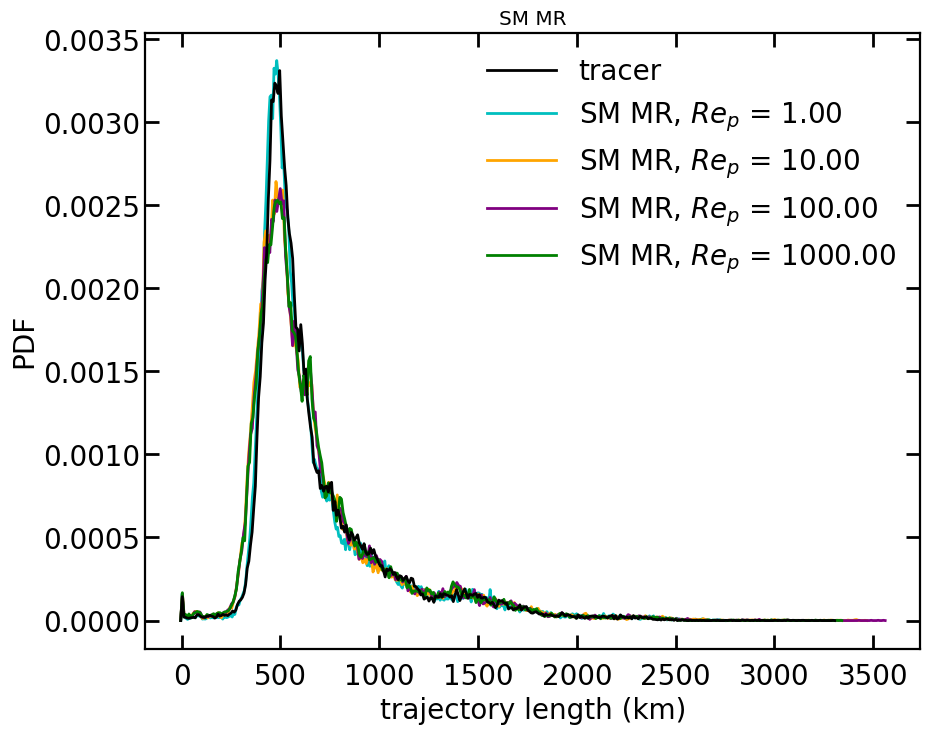

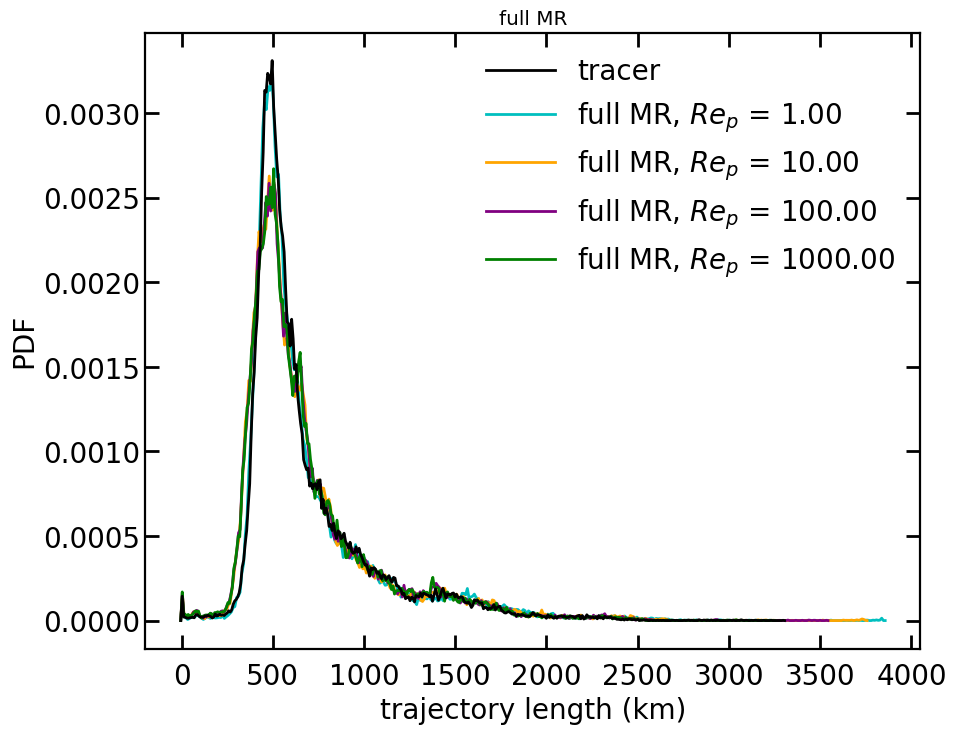

In [15]:
#  plot PDF of total trajectory length
for pt in particle_types[1:]:
    fig,ax=plt.subplots()
    Tmax = 720
    # plot total trajectory lengh pdf
    # color_particles = {'tracer':'navy','inertial':'firebrick','inertial_SM':'green'}

    legend=[]
    Tmax=720

    legend.append('tracer')
    data_arrays = list(data['tracer'][coriolis][None].values())
    combined_data = xr.concat(data_arrays, dim="starting_days")

    average_data = combined_data.traj_length.mean(dim="starting_days",skipna=True)

    bins, pdf = make_PDF( average_data[:,Tmax-1].values.flatten(),401, norm=True)


    ax.plot(bins,pdf,'-',color='black',zorder=20)

    # pt = 'inertial_SM_Rep_constant'
    for Rep, color in zip(Replist,color_array): 
        legend.append(simtype[pt]+', $Re_p$ = {:.02f}'.format(Rep))
        data_arrays = list(data[pt][coriolis][Rep].values())
        combined_data = xr.concat(data_arrays, dim="starting_days")

        average_data = combined_data.traj_length.mean(dim="starting_days",skipna=True)

        bins, pdf = make_PDF( average_data[:,Tmax-1].values.flatten(),401, norm=True)
        ax.plot(bins,pdf,'-',color=color)
    ax.set_title(simtype[pt])
    ax.legend(legend)
    ax.set_ylabel("PDF")
    ax.set_xlabel("trajectory length (km)")


    #tidal_av
   


# for particle_type in particle_types:
#     bins, pdf = make_PDF(arrays[particle_type+'_tidal_av'],401, norm=True)
#     ax.plot(bins,pdf,'--',color=color_particles[particle_type])
#     legend.append(particle_type+' tidal av')



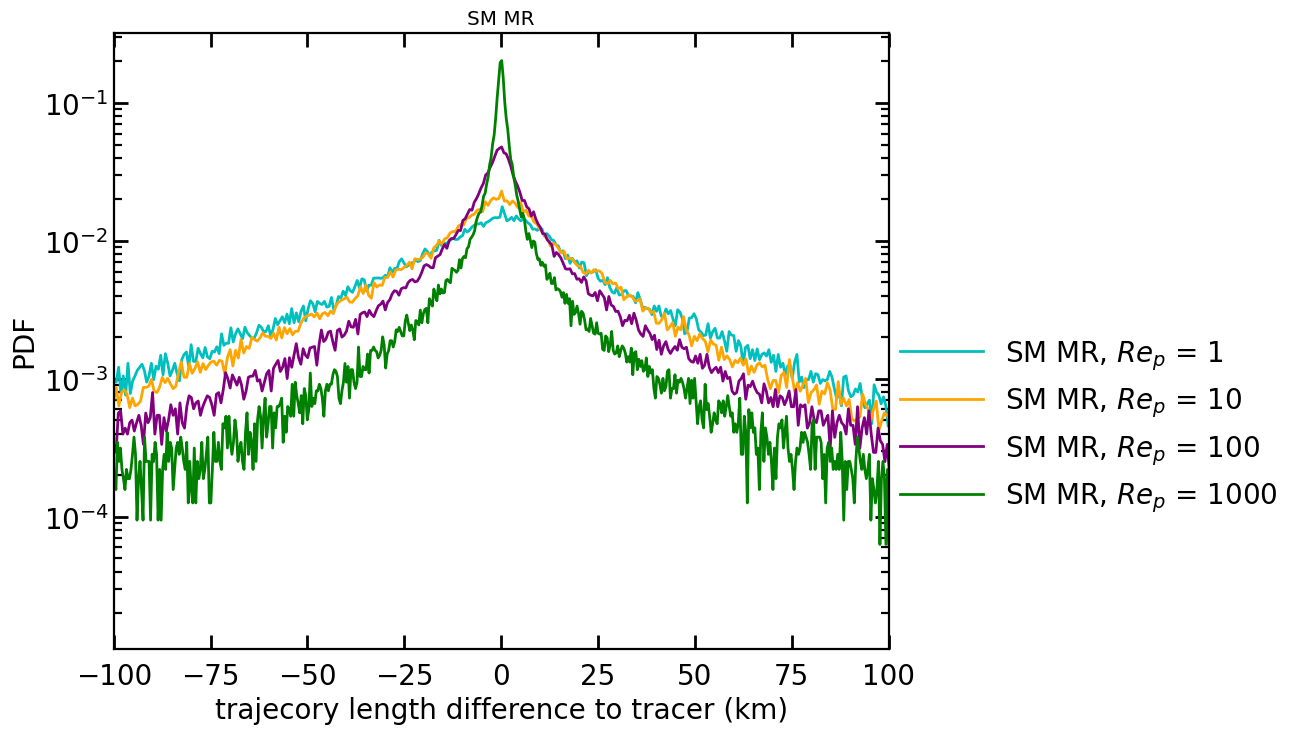

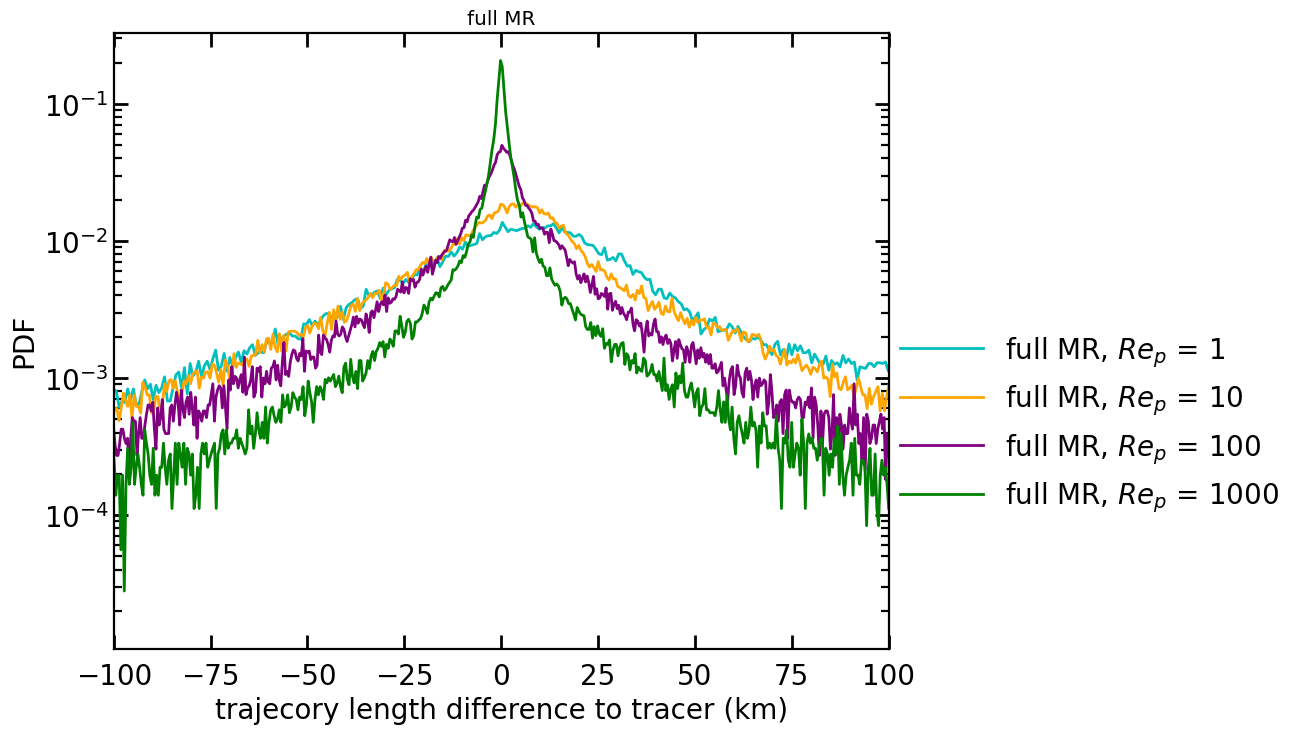

In [55]:
# plot PDF difference trajecory length and rest of particles
for pt in particle_types[1:]:
    fig, ax = plt.subplots()

    data_arrays_tracer = list(data['tracer'][coriolis][None].values())
    combined_data_tracer = xr.concat(data_arrays_tracer, dim="starting_days")

    legend = []
    for Rep, color in zip(Replist,color_array):
        data_arrays_Rep = list(data[pt][coriolis][Rep].values())
        combined_data_Rep = xr.concat(data_arrays_Rep, dim="starting_days") 
        
        diff = combined_data_Rep.traj_length - combined_data_tracer.traj_length
        average_data = diff.mean(dim="starting_days",skipna=True)
        bins, pdf = make_PDF( average_data[:,Tmax-1].values.flatten(),5001, norm=True)
        ax.plot(bins,pdf,'-',color=color)
        legend.append(simtype[pt]+', $Re_p$ = {:d}'.format(Rep))
    ax.set_title(simtype[pt])
    ax.legend(legend,loc=(1,0.2))
    ax.set_ylabel("PDF")
    ax.set_xlabel("trajecory length difference to tracer (km)")
    ax.set_xlim(-100,100)
    ax.set_yscale('log')

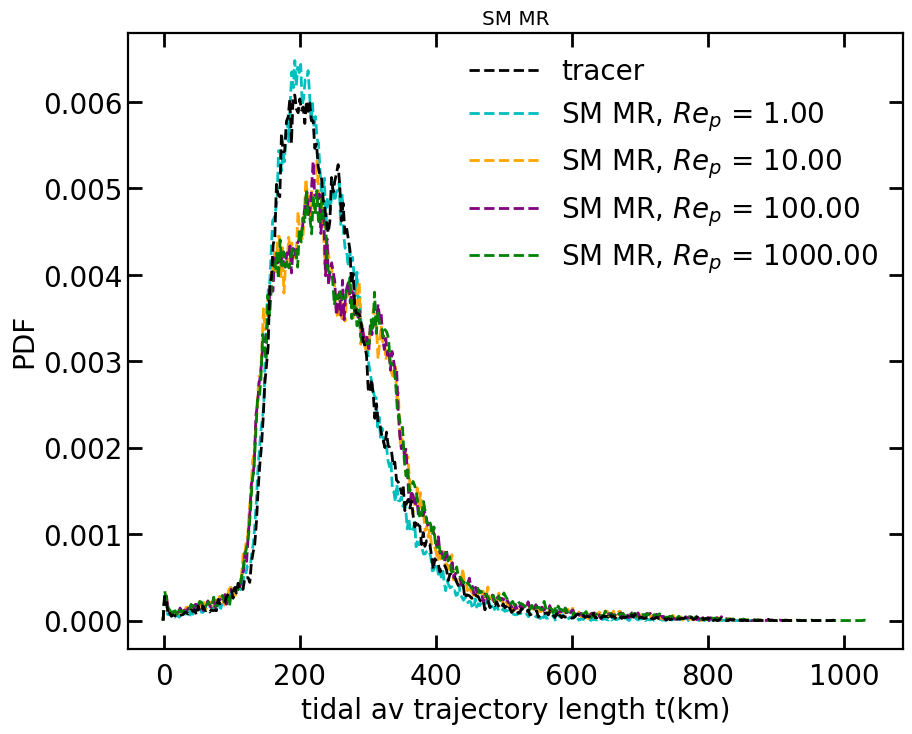

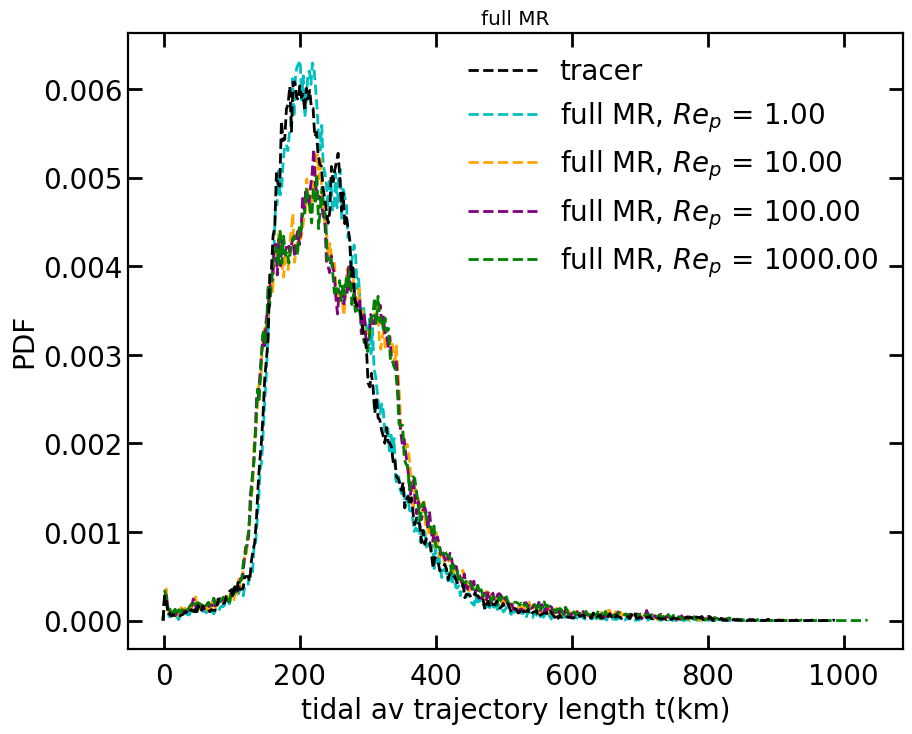

In [16]:
#  plot PDF of total trajectory length tidal av
for pt in particle_types[1:]:
    fig,ax=plt.subplots()
    Tmax = 720
    # plot total trajectory lengh pdf
    # color_particles = {'tracer':'navy','inertial':'firebrick','inertial_SM':'green'}

    legend=[]
    Tmax=720


    legend.append('tracer')
    data_arrays = list(data['tracer'][coriolis][None].values())
    combined_data = xr.concat(data_arrays, dim="starting_days")

    average_data = combined_data.traj_length_tidal_av.mean(dim="starting_days",skipna=True)

    bins, pdf = make_PDF( average_data[:,Tmax-1].values.flatten(),401, norm=True)
    ax.plot(bins,pdf,'--',color='black',zorder=20)

    for Rep, color in zip(Replist,color_array): 
        legend.append(simtype[pt]+', $Re_p$ = {:.02f}'.format(Rep))
        data_arrays = list(data[pt][coriolis][Rep].values())
        combined_data = xr.concat(data_arrays, dim="starting_days")

        average_data = combined_data.traj_length_tidal_av.mean(dim="starting_days",skipna=True)

        bins, pdf = make_PDF( average_data[:,Tmax-1].values.flatten(),401, norm=True)
        ax.plot(bins,pdf,'--',color=color)
    ax.set_title(simtype[pt])



    ax.legend(legend)
    ax.set_ylabel("PDF")
    ax.set_xlabel("tidal av trajectory length t(km)")

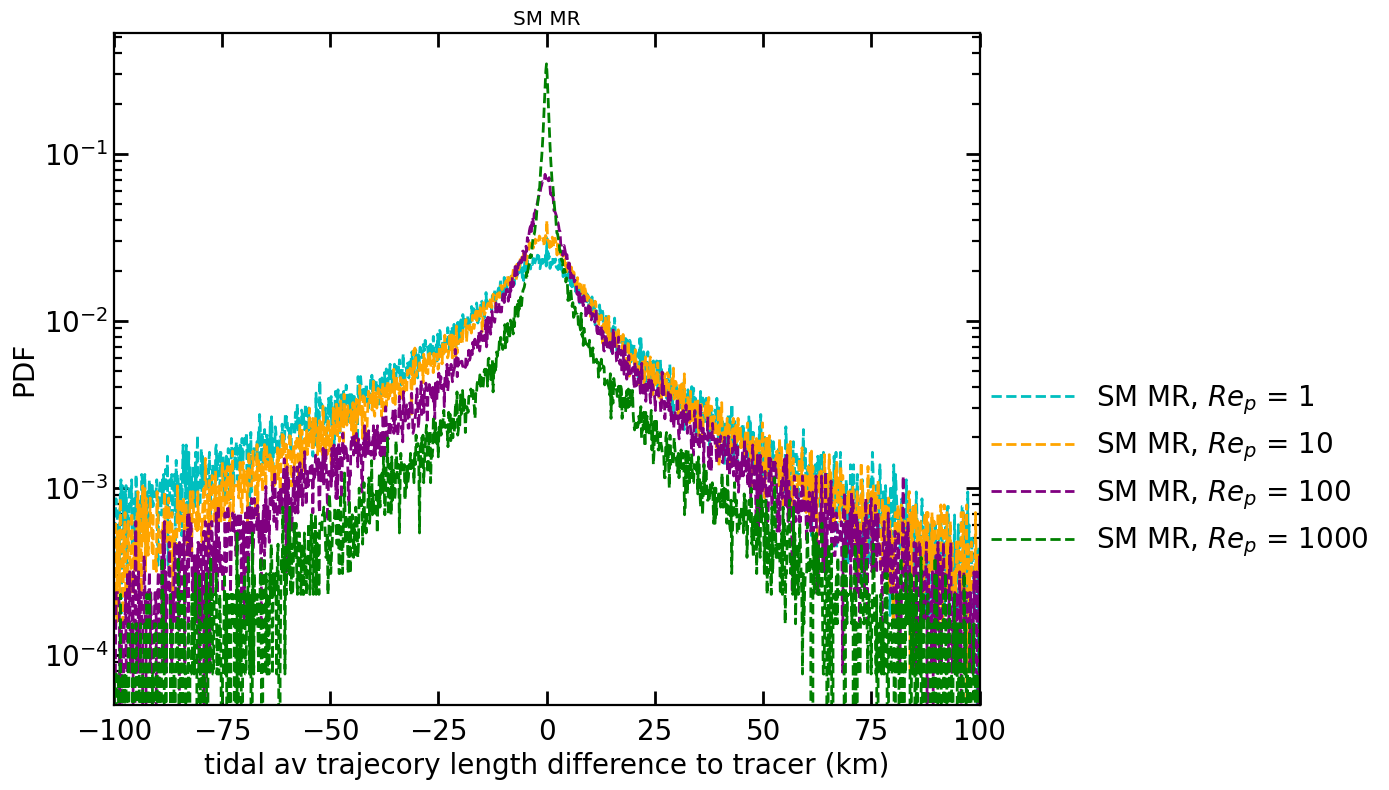

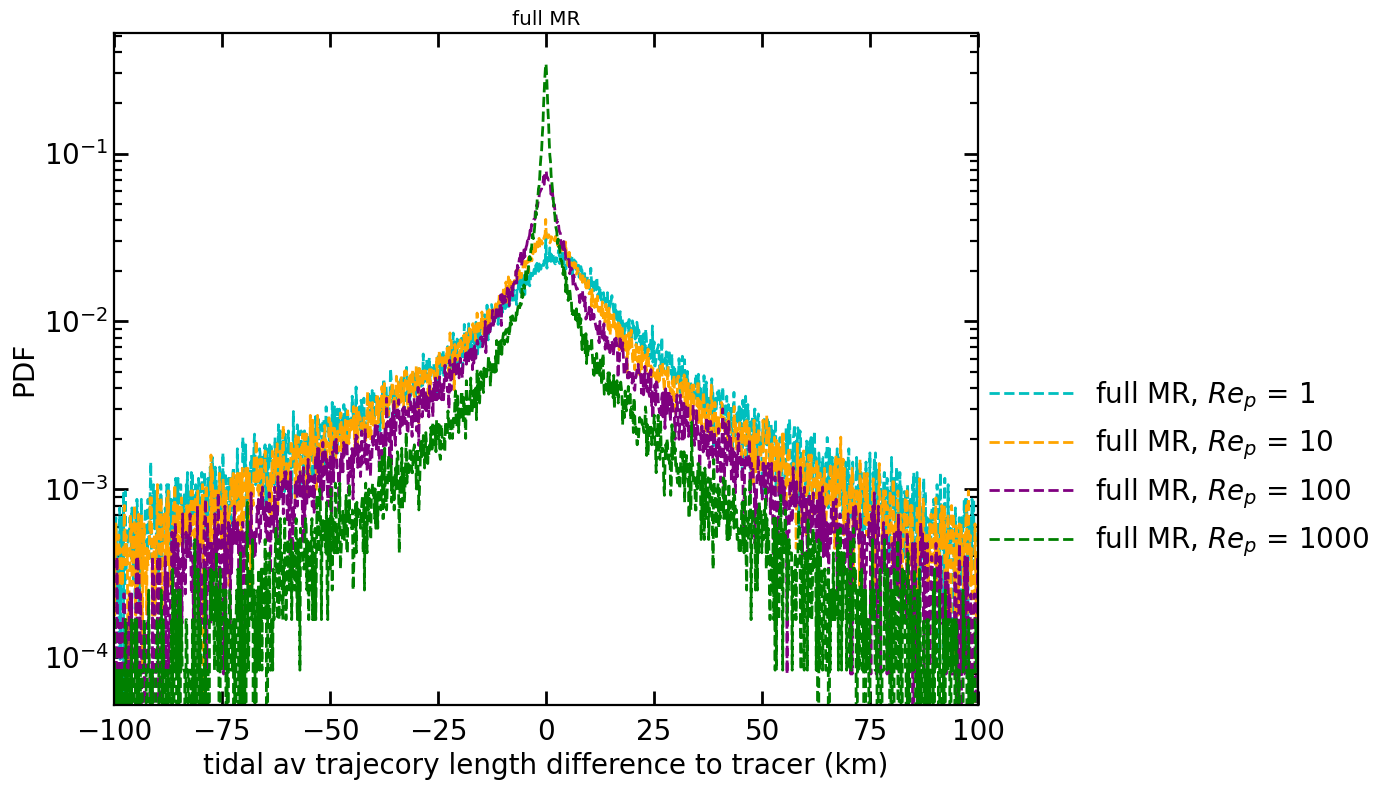

In [57]:
# plot PDF difference trajecory length and rest of particles tidal averaged data
for pt in particle_types[1:]:
    fig, ax = plt.subplots(figsize=(14,8))
    Tmax_tides = 720
    data_arrays_tracer = list(data['tracer'][coriolis][None].values())
    combined_data_tracer = xr.concat(data_arrays_tracer, dim="starting_days")

    legend = []

    for Rep, color in zip(Replist,color_array):
        data_arrays_Rep = list(data[pt][coriolis][Rep].values())
        combined_data_Rep = xr.concat(data_arrays_Rep, dim="starting_days") 
        
        diff = combined_data_Rep.traj_length_tidal_av - combined_data_tracer.traj_length_tidal_av
        average_data = diff.mean(dim="starting_days",skipna=True)
        bins, pdf = make_PDF( average_data[:,Tmax_tides-1].values.flatten(),5001, norm=True)
        ax.plot(bins,pdf,'--',color=color)
        legend.append(simtype[pt]+', $Re_p$ = {:d}'.format(Rep))

    ax.legend(legend,loc=(1,0.2))
    ax.set_title(simtype[pt])
    ax.set_ylabel("PDF")
    ax.set_xlabel("tidal av trajecory length difference to tracer (km)")
    ax.set_xlim(-100,100)
    ax.set_yscale('log')
    fig.tight_layout()


In [17]:
# Relative dispersion


for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    date = f'{year:04d}/{month:02d}' #'inertial_SM_drag_Rep','inertial_Rep_constant','inertial_SM_Rep_constant']
    ds_tracer = data['tracer'][coriolis][None][date]
    for pt in particle_types[1:]:
        for Rep in Replist:
            ds_Rep = data[pt][coriolis][Rep][date]
            dist= Haversine(ds_Rep['lon'],ds_Rep['lat'],
                                ds_tracer['lon'],ds_tracer['lat'])
            data[pt][coriolis][Rep][date]=data[pt][coriolis][Rep][date].assign(dist = dist)
            data[pt][coriolis][Rep][date]=data[pt][coriolis][Rep][date].rename({'dist':'dist_to_tracer'})

            #tial av
            dist_tidal_av= Haversine(ds_Rep['lon_tidal_av'],ds_Rep['lat_tidal_av'],
                                ds_tracer['lon_tidal_av'],ds_tracer['lat_tidal_av'])
            data[pt][coriolis][Rep][date]=data[pt][coriolis][Rep][date].assign(dist_tidal_av = dist_tidal_av)
            data[pt][coriolis][Rep][date]=data[pt][coriolis][Rep][date].rename({'dist_tidal_av':'dist_to_tracer_tidal_av'})


2023-09-01 00:00:00
2023-10-01 00:00:00


2023-09-01 00:00:00
1
10
100
1000
2023-10-01 00:00:00
1
10
100
1000
2023-09-01 00:00:00
1
10
100
1000
2023-10-01 00:00:00
1
10
100
1000


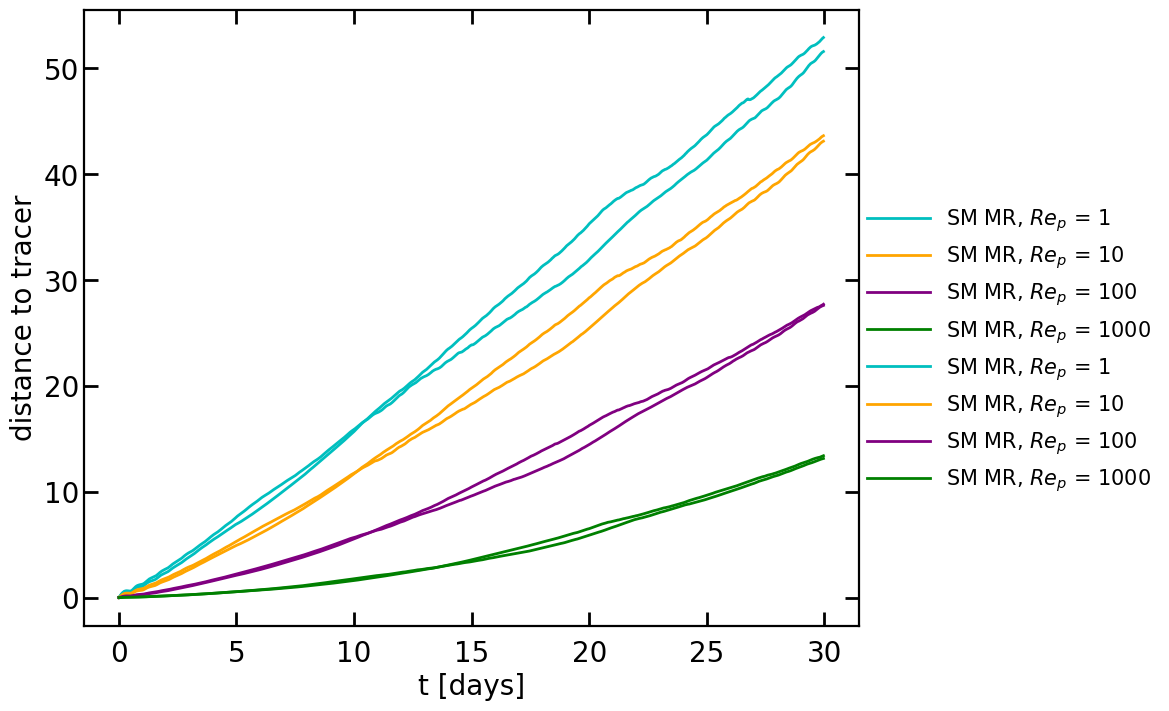

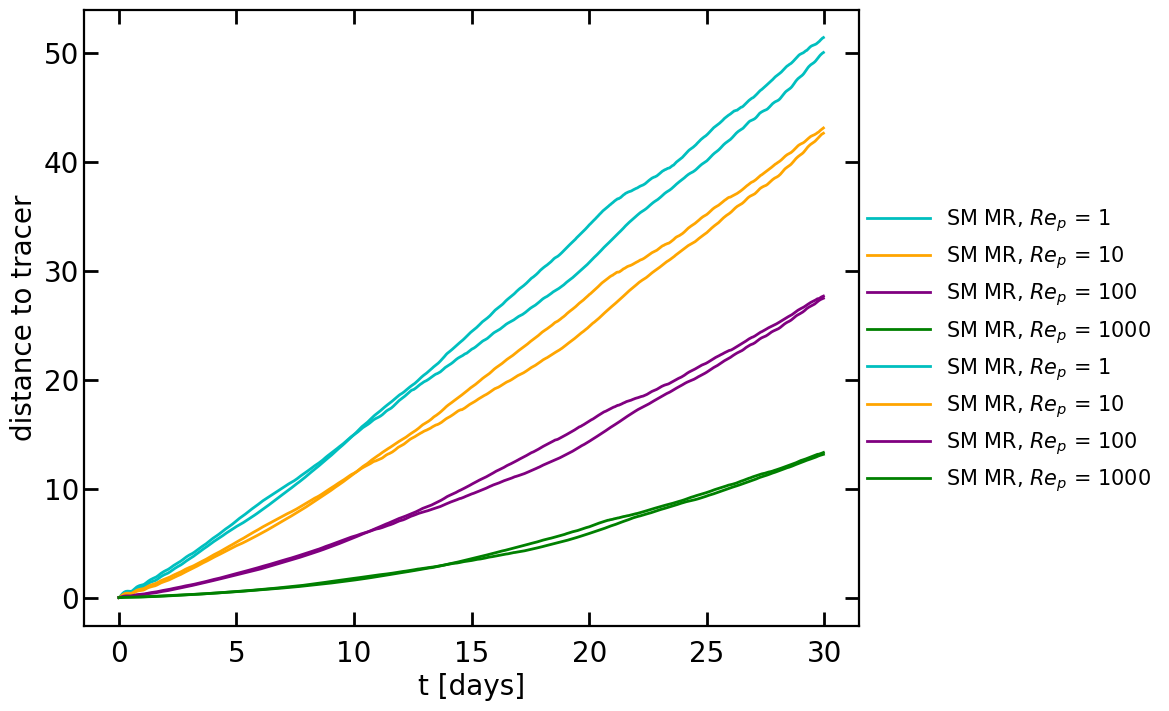

In [61]:
# plot distribution final distance between particles
# slow manifold finds bigger seperation distance (as expected because more oscillations)
tfinal = 799
markerlist=np.array(['-','--','-.',':','-','--','-.',':'])

i=0

legend=[]
for pt in particle_types[1:]:   
    fig,ax=plt.subplots()
    for starttime in starttimes:
        print(starttime)
        year = starttime.year
        month = starttime.month
        date = f'{year:04d}/{month:02d}'
        for Rep, color in zip(Replist,color_array):
            print(Rep)
            values=data[pt][coriolis][Rep][date]['dist_to_tracer'].mean(dim='trajectory',skipna=True).values
            tlist=np.arange(0,values.size,1)/24
        
            ax.plot(tlist[:720], values[:720], '-', color=color)

        
            legend.append(simtype[pt]+', $Re_p$ = {:d}'.format(Rep))
    ax.legend(legend,loc=(1,0.2), fontsize=15)
    ax.set_xlabel('t [days]')
    ax.set_ylabel('distance to tracer')

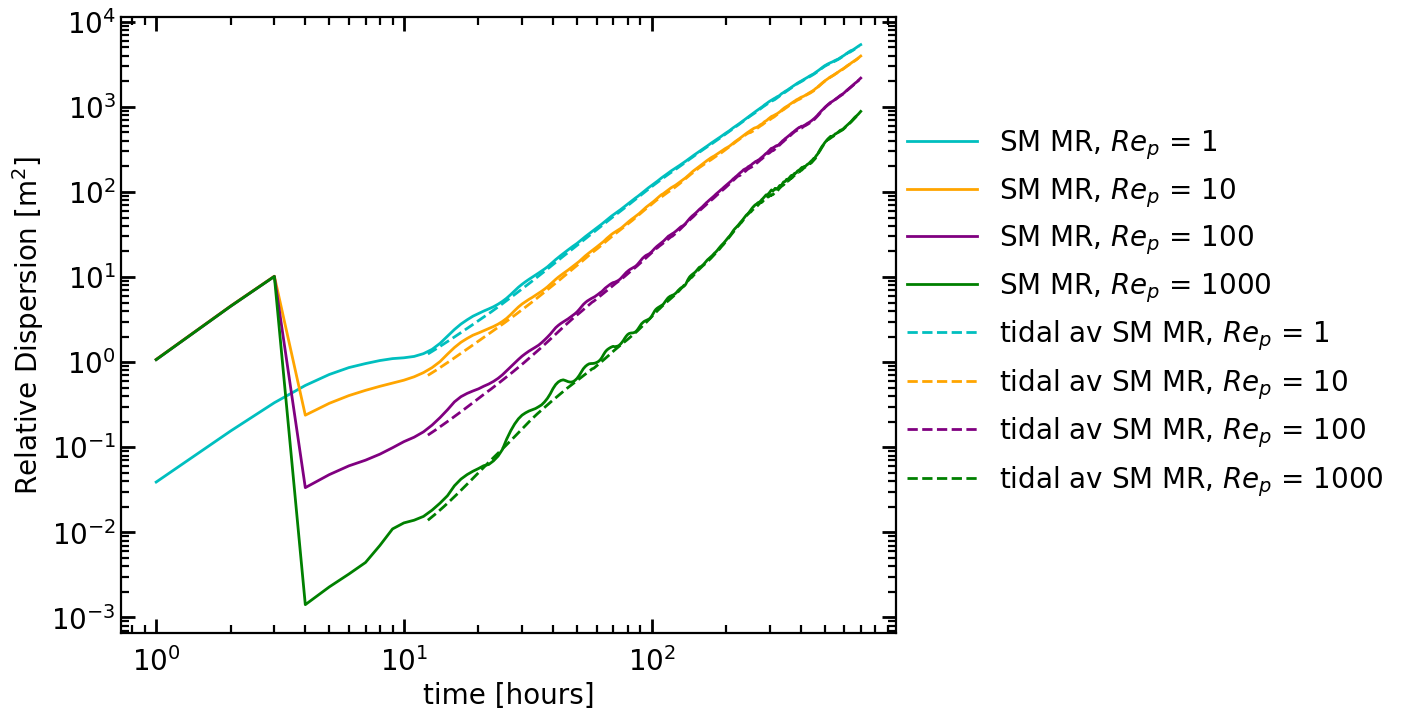

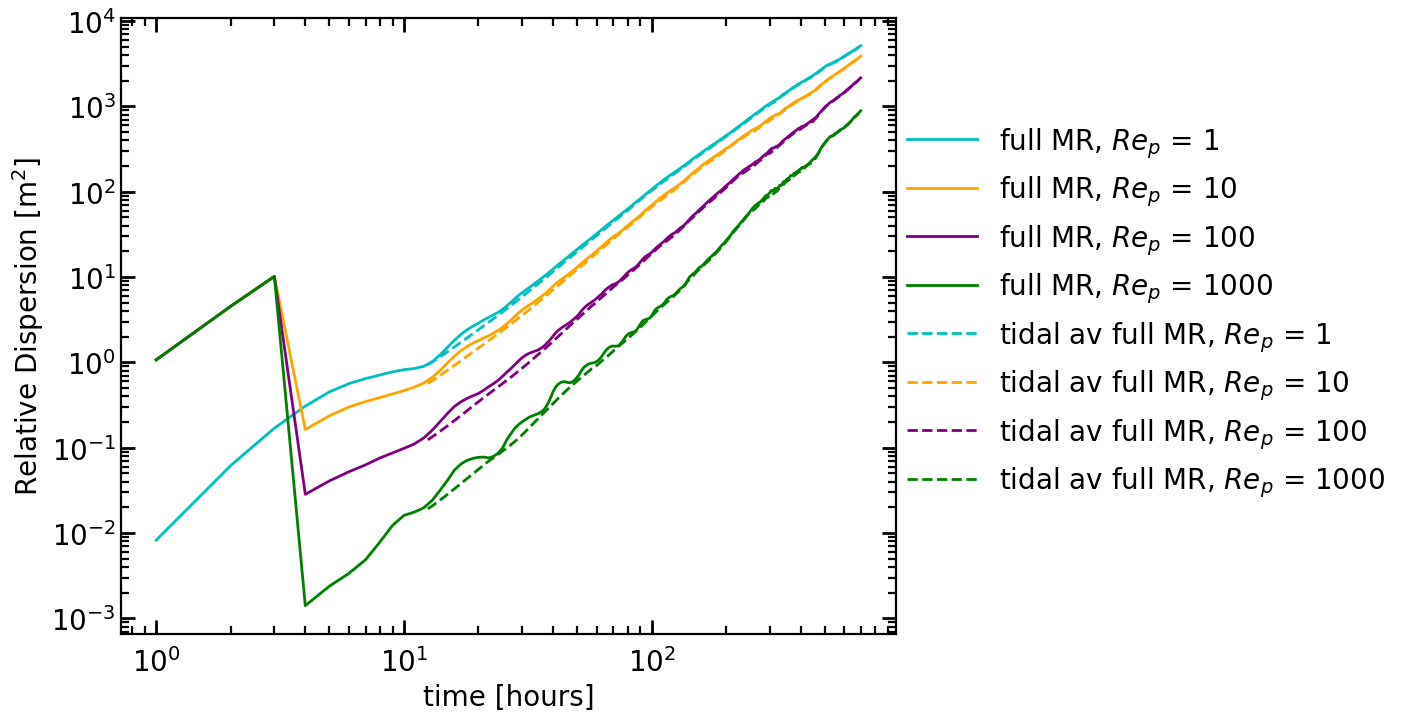

In [18]:
#relative dispersion

for pt in particle_types[1:]:
    fig,ax=plt.subplots()
    legend=[]
    Tmax=700
    for Rep,color in zip(Replist,color_array):
        data_arrays = list(data[pt][coriolis][Rep].values())
        combined_data = xr.concat(data_arrays, dim ='starting_days')
        dsquared = (combined_data.dist_to_tracer**2).mean(dim='trajectory',skipna=True)
        dsquared_averaged = dsquared.mean(dim='starting_days',skipna=True)
        tlist=np.arange(1,Tmax)
        ax.plot(tlist,dsquared_averaged[1:Tmax],color=color)
        legend.append(simtype[pt]+', $Re_p$ = {:d}'.format(Rep))

    #add tidal average
    for Rep,color in zip(Replist,color_array):
        data_arrays = list(data[pt][coriolis][Rep].values())
        combined_data = xr.concat(data_arrays, dim ='starting_days')
        dsquared = (combined_data.dist_to_tracer_tidal_av**2).mean(dim='trajectory',skipna=True)
        dsquared_averaged = dsquared.mean(dim='starting_days',skipna=True)
        tlist=np.arange(window,Tmax)-window/2
        ax.plot(tlist,dsquared_averaged[window:Tmax],'--',color=color,zorder=-5)
        legend.append('tidal av '+simtype[pt]+', $Re_p$ = {:d}'.format(Rep))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Relative Dispersion [m$^2$]')
    ax.set_xlabel('time [hours]')
    ax.legend(legend,loc=(1,0.2))


## distribution analysis
Now want to show that distribution itself is also a function of Reynolds number 
where with lower reynolds numbers there is more structure (divergence/convergence points)


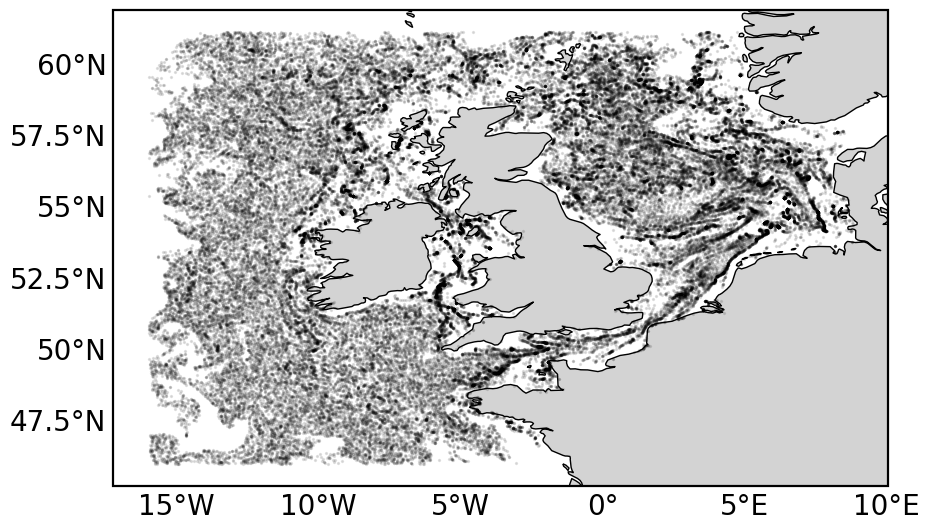

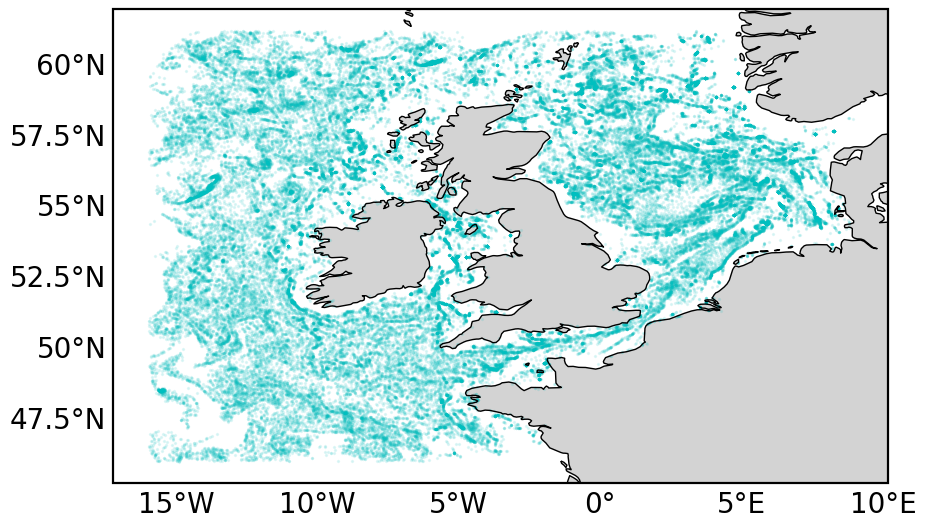

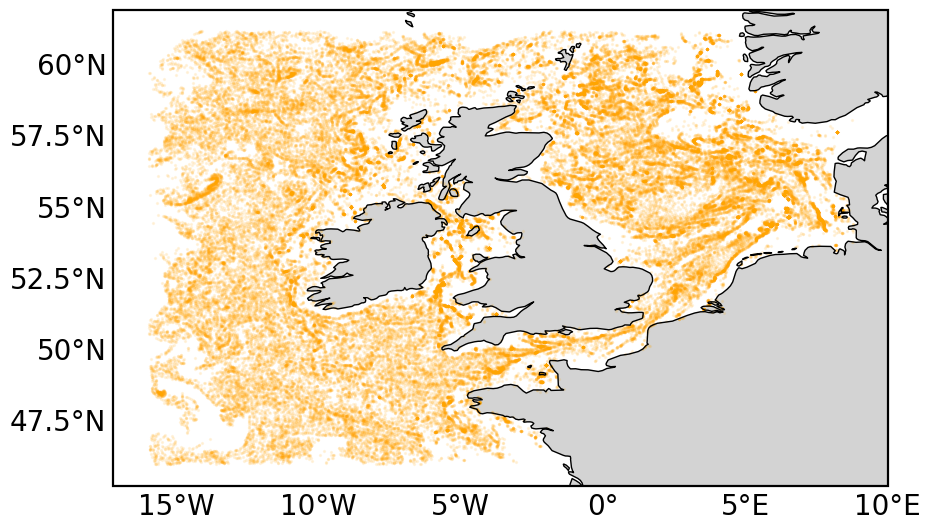

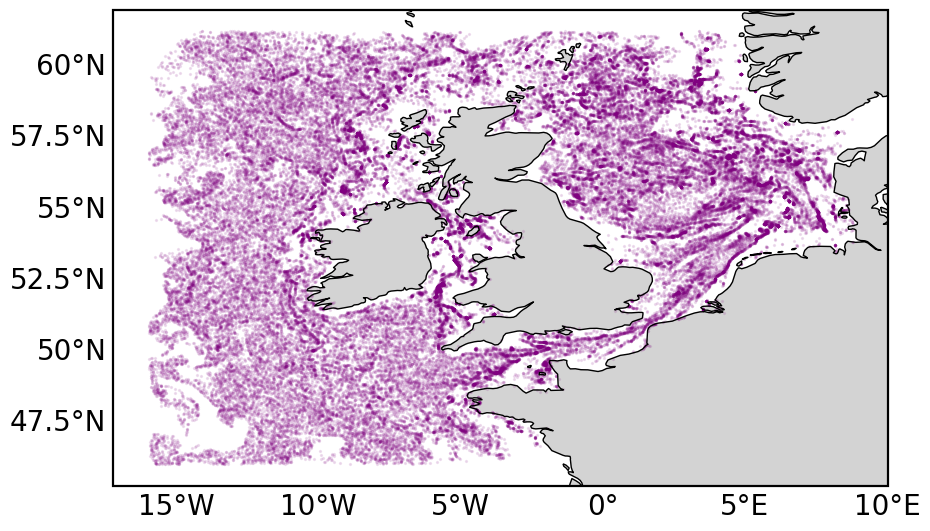

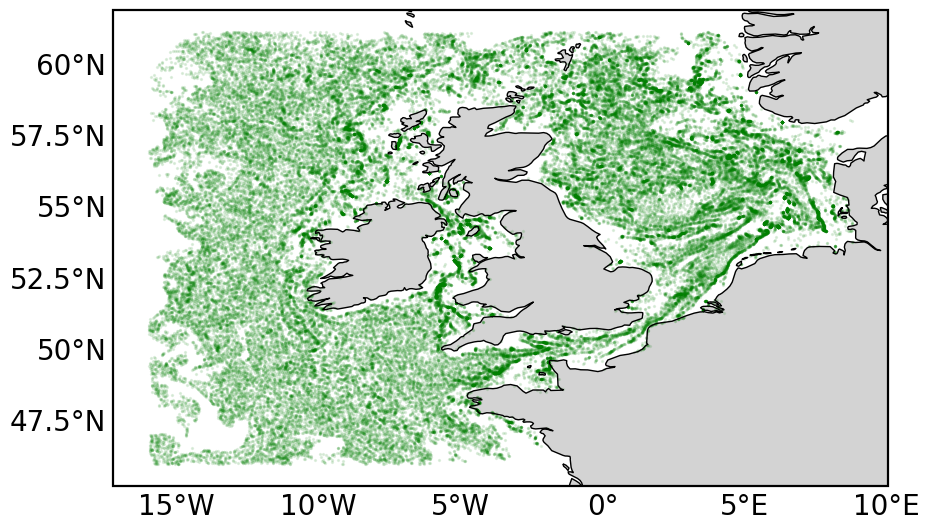

In [21]:
# show final shapshot
startime = starttimes[0]
year = starttime.year
month = starttime.month
date = f'{year:04d}/{month:02d}'
pt = 'inertial_SM_Rep_constant'
Tmax=700
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

ax.scatter(data['tracer'][coriolis][None][date].lon[:,Tmax],data['tracer'][coriolis][None][date].lat[:,Tmax],marker='o',s=2,alpha=0.1,color='k')
ax.coastlines()
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}


for Rep, color in zip(Replist,color_array):
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ax.scatter(data[pt][coriolis][Rep][date].lon[:,Tmax],data[pt][coriolis][Rep][date].lat[:,Tmax],marker='o',s=2,alpha=0.1,color=color)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}




In [26]:
hex_res = 5
sim_domain = { 
    "type":"Polygon",
    "coordinates": [
   [[9.977004051208496-0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,61.28188705444336-0.5]]
     ]}
hexagons = h3.polygon_to_cells(h3.geo_to_h3shape(sim_domain), hex_res)
hexbin_grid = hexfunc.hexGrid(hexagons, h3_res=hex_res)
hexbin_grid.process_hexagons()

# fig = plt.figure(figsize=(10, 8))
# ax = plt.axes(projection=cart.crs.PlateCarree())
# ax.add_feature(cart.feature.LAND)
# ax.add_feature(cart.feature.OCEAN)
# ax.add_feature(cart.feature.COASTLINE)
# ax.add_feature(cart.feature.BORDERS, linestyle=':')
# ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
# ax.add_geometries([shape(sim_domain)], cart.crs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.5)


# # ax.scatter(lons[:,0],lats[:,0],color='k')
# ax.scatter( hexbin_grid.centroid_lons, hexbin_grid.centroid_lats,color='red',zorder=200)

# ax.set_xlim(-20,15)
# ax.set_ylim(40,70)

# # check lon lats 

In [ ]:
# need to set landmask to get rid of zeros which should not be there? 

In [77]:
probability_set = {}
Tmax=719

for pt in particle_types:
    probability_set[pt]={}
    for coriolis in [True]:
        probability_set[pt][coriolis]={}
        if(pt=='tracer'):
            probability_set[pt][coriolis][None]={}
        else:
            for Rep in Replist:
                probability_set[pt][coriolis][Rep]={}

for starttime in starttimes:
    year = starttime.year
    month = starttime.month
    date = f'{year:04d}/{month:02d}'
    print(date)
    for pt in particle_types:
        if(pt =='tracer'):
            ds =data[pt][coriolis][None][date]
            
            probability_set[pt][coriolis][None][date] =(hexbin_grid.count_2d(ds.lon[:, Tmax].values,ds.lat[:,Tmax].values, normalize=False))
        else:
            for Rep in Replist:
                print(Rep)
                ds =data[pt][coriolis][Rep][date]
                probability_set[pt][coriolis][Rep][date] = (hexbin_grid.count_2d(ds.lon[:, Tmax].values,ds.lat[:,Tmax].values, normalize=False))

2023/09
1
10
100
1000
1
10
100
1000
2023/10
1
10
100
1000
1
10
100
1000


In [68]:


probability_set_time={}
starttime=starttimes[0]
year = starttime.year
month = starttime.month
date = f'{year:04d}/{month:02d}'
pt = 'inertial_SM_Rep_constant'
Tlist = [0,24*15-1,719]

for t in Tlist:
    print(t)
    ds =data['tracer'][coriolis][None][date]
    probability_set_time[t] = (hexbin_grid.count_2d(ds.lon[:, t].values,ds.lat[:,t].values, normalize=False))

0
359
719


Text(0, 0.5, 'PDF')

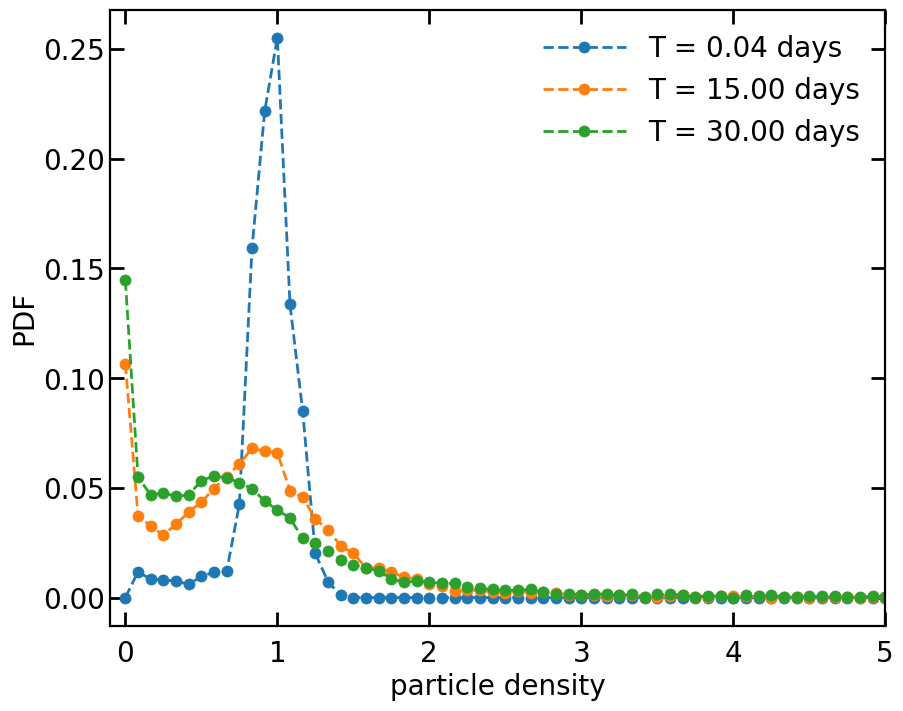

In [38]:
fig,ax = plt.subplots()
norm =12
tlegend=[]
for t in Tlist:
    bins, pdf = make_PDF(probability_set_time[t][probability_set_time[0]>0],261,norm=True,min=-0.5,max=260.5)
    ax.plot(bins[1:]/norm,pdf[1:],'--o')
    tlegend.append(f'T = {(t+1)/24:.02f} days')
ax.axvline(12,color='grey',zorder=-20)
ax.legend(tlegend)
ax.set_xlim(-0.1,5)
ax.set_xlabel('particle density')
ax.set_ylabel('PDF')

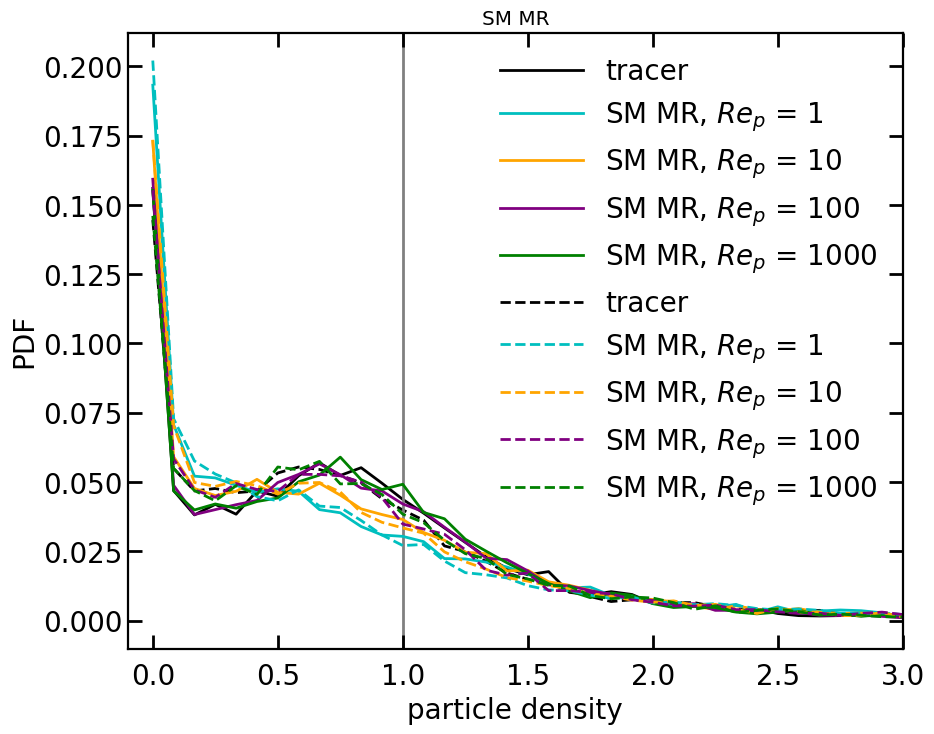

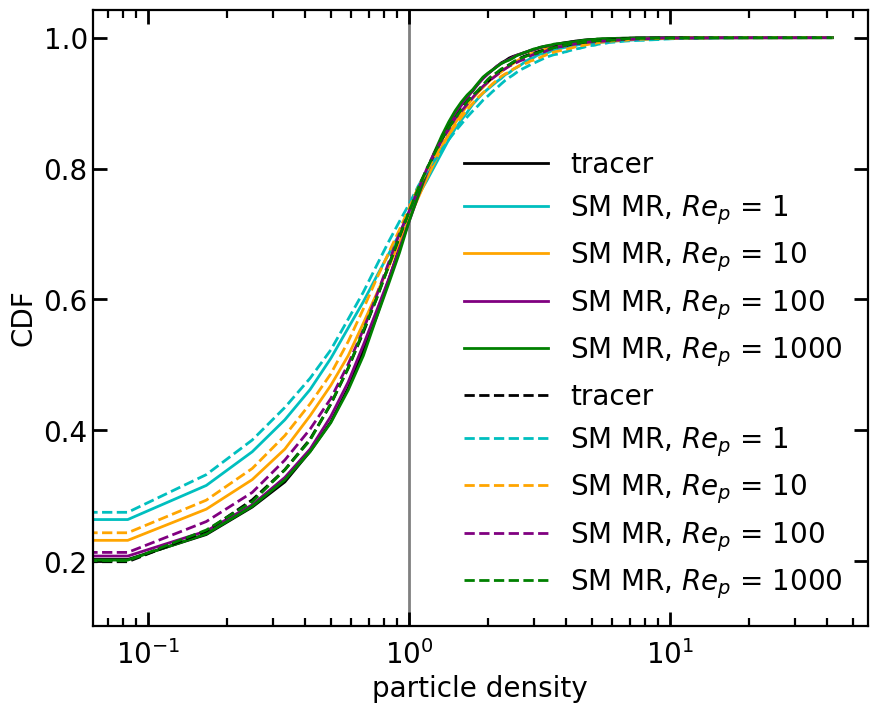

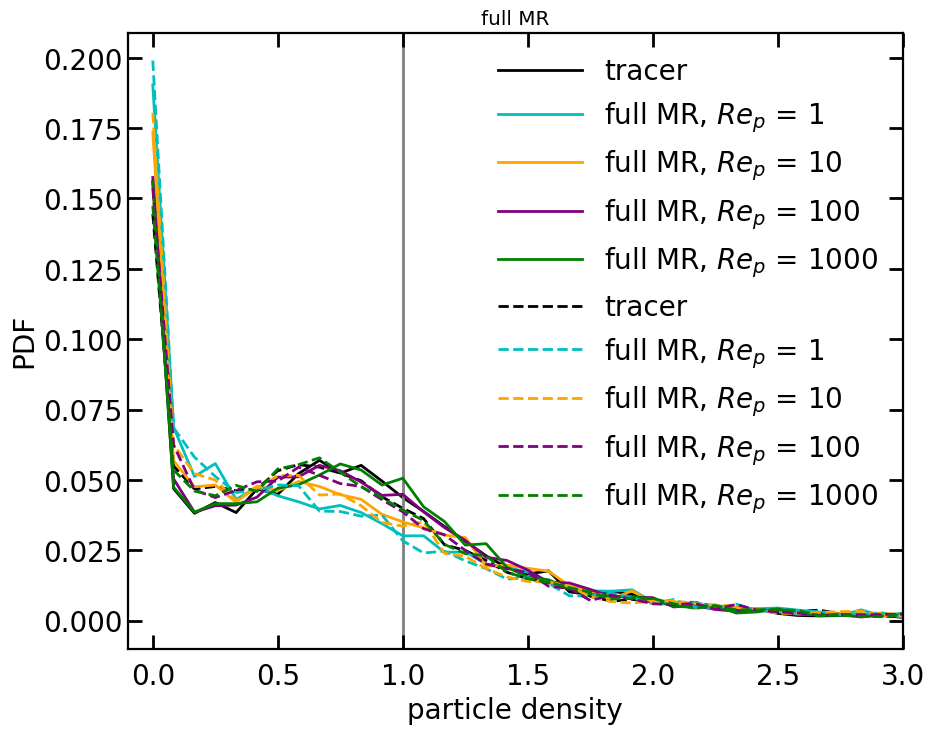

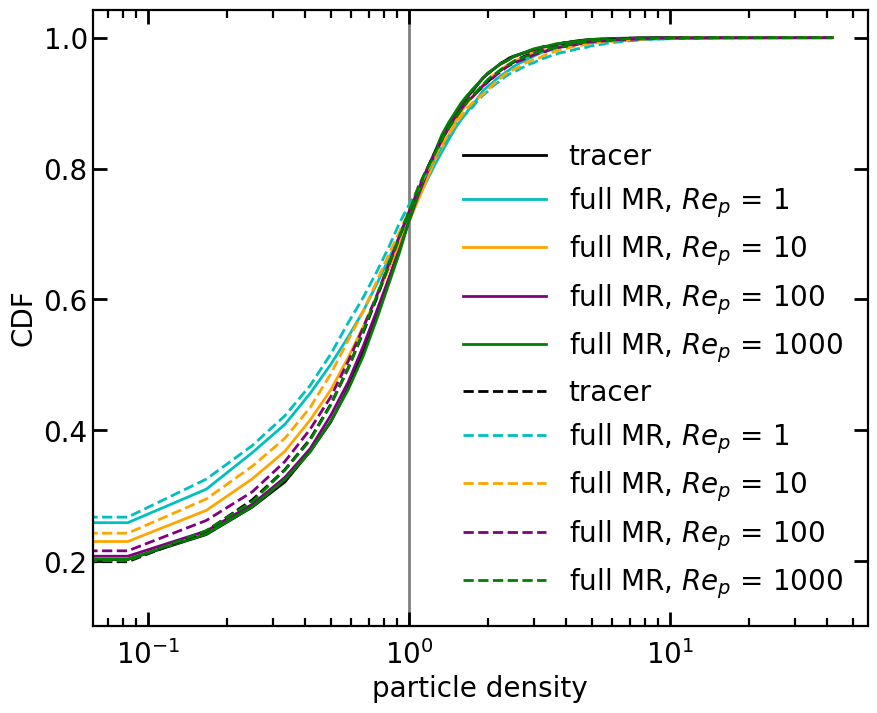

In [ ]:
for pt in particle_types[1:]:
    fig, ax =plt.subplots()
    fig2, ax2 =plt.subplots()
    legend=[]
    norm = 12
    nbins = 501
    max = 500.5
    coriolis =True
    markers=['-','--']
    for starttime, marker in zip(starttimes[0:1],markers) :
    # starttime=starttimes[1]
        year = starttime.year
        month = starttime.month
        date = f'{year:04d}/{month:02d}'

        bins,pdf = make_PDF(probability_set['tracer'][coriolis][None][date][probability_set_time[0]>0],nbins=nbins,norm=True,min=-0.5,max=max)
        ax.plot(bins[1:]/norm,pdf[1:],marker,color='k',zorder=-20)
        dx = bins[2]-bins[1]
        ax2.plot(bins[1:]/norm,np.cumsum(pdf[1:]*dx),marker,color='k')
        legend.append('tracer')

        # bins,pdf = make_PDF(probability_set_tracer,norm=False,bins=100,min=0,max=100)
        for Rep, color in zip(Replist,color_array):
            bins,pdf = make_PDF(probability_set[pt][coriolis][Rep][date][probability_set_time[0]>0],nbins=nbins,norm=True,min=-0.5,max=max)
            ax.plot(bins[1:]/norm,pdf[1:],marker,color=color,)
            dx = bins[2]-bins[1]
            ax2.plot(bins[1:]/norm,np.cumsum(pdf[1:]*dx),marker,color=color)
            legend.append(simtype[pt]+', $Re_p$ = {:d}'.format(Rep))
    # ax.set_yscale('log')
    ax.legend(legend)
    ax.set_xlim(-0.1,3)
    ax.axvline(1,color='grey',zorder=-20)
    ax2.legend(legend)
    ax2.set_xscale('log')

    ax2.axvline(1,color='grey',zorder=-20)
    # ax2.set_xlim(10,15)
    # ax2.set_ylim(0.6,0.8)
    ax.set_xlabel('particle density')
    ax.set_ylabel('PDF')
    ax.set_title(simtype[pt])



    ax2.set_xlabel('particle density')
    ax2.set_ylabel('CDF')

Text(0, 0.5, 'CDF')

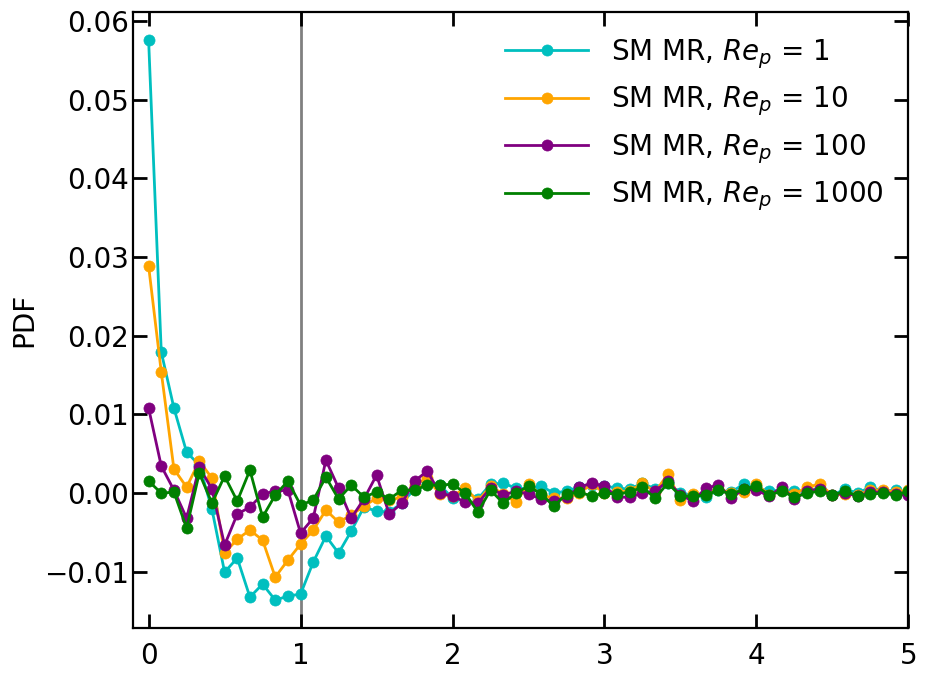

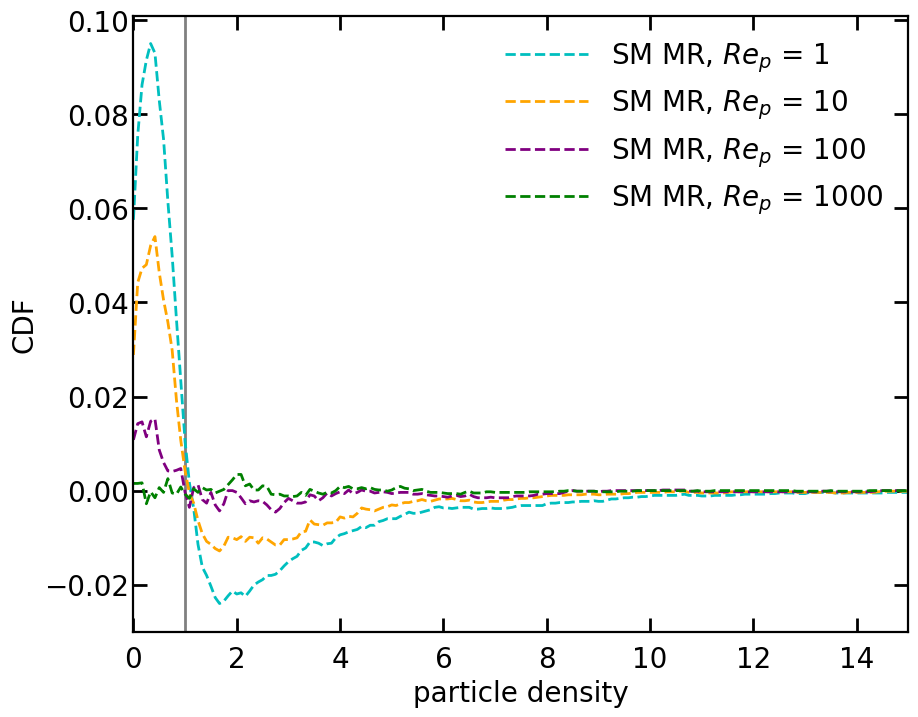

In [36]:
fig, ax =plt.subplots()
fig2, ax2 =plt.subplots()
legend=[]
norm = 12
max= 500.5
nbins = 501
bins_tracer,pdf_tracer = make_PDF(probability_set_tracer[probability_set_time[0]>0],nbins = nbins,norm=True,min=-0.5,max=max)
# ax.plot(bins_tracer[1:]/norm,pdf_tracer[1:],'-s',color='k',zorder=-20)
dx = bins[2]-bins[1]
cdf_tracer =np.cumsum(pdf_tracer*dx)
# ax2.plot(bins[1:]/norm,np.cumsum(pdf[1:]*dx),'-',color='k')
# legend.append('tracer')

# bins,pdf = make_PDF(probability_set_tracer,norm=False,bins=100,min=0,max=100)
for Rep, color in zip(Replist,color_array):
    bins,pdf = make_PDF(probability_set_Rep[Rep][probability_set_time[0]>0],nbins =nbins,norm=True,min=-0.5,max=max)
    ax.plot(bins[1:]/norm,pdf[1:]-pdf_tracer[1:],'-o',color=color,)
    dx = bins[2]-bins[1]
    ax2.plot(bins[1:]/norm,np.cumsum(pdf[1:]*dx)-cdf_tracer[1:],'--',color=color)
    legend.append('SM MR, $Re_p$ = {:d}'.format(Rep))
# ax.set_yscale('log')
ax.legend(legend)
ax.set_xlim(-0.1,5)
# ax.set_xscale('log')
ax.axvline(1,color='grey',zorder=-20)
ax2.legend(legend)
# ax2.set_xscale('log')

ax2.axvline(1,color='grey',zorder=-20)
ax2.set_xlim(0,15)
# ax2.set_ylim(0.6,0.8)
ax.set_xlabel('particle density')
ax.set_ylabel('PDF')
ax.set_xlabel('')

ax2.set_xlabel('particle density')
ax2.set_ylabel('CDF')